In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.cluster import KMeans
from scipy.sparse import csgraph, csr_matrix
import json


In [2]:
G = nx.Graph()

with open("CA-GrQc.txt") as f:
    for line in f:
        if line.startswith('#'):
            continue
        node1, node2 = map(int, line.split())
        G.add_edge(node1, node2)
        

# Quick check
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")


Number of nodes: 5242
Number of edges: 14496


## Start 

In [3]:
A = nx.to_numpy_array(G)

degrees = [G.degree(n) for n in G.nodes()]
D = np.diag(degrees)

L = D-A

In [4]:
eigval, eigvectors = np.linalg.eigh(L)
e2 = eigvectors[:, 1] # get 2nd eigenvector

In [5]:
e2

array([-1.12401045e-22,  5.07037996e-18,  3.42626579e-18, ...,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00])

In [6]:

## My way
# partitions = {0:[], 1:[]}

# for i, val in enumerate(e2):
#     if val<0:
#         partitions[0].append(i)
#     else:
#          partitions[1].append(i)


# Vectorized way - for longer lists - much more efficient (parallel)

e2 = np.array(e2)  # make sure e2 is a numpy array

# G.nodes() as a list in the same order used to make adjacency matrix
nodes = list(G.nodes())

partitions = {
    0: [nodes[i] for i in np.where(e2 < 0)[0]],
    1: [nodes[i] for i in np.where(e2 >= 0)[0]]
}
   

In [18]:
communities = [set(nodes) for nodes in partitions.values()]
mod = nx.algorithms.community.modularity(G, communities)
print("Modularity:", mod)


Modularity: 0.23597738454682174


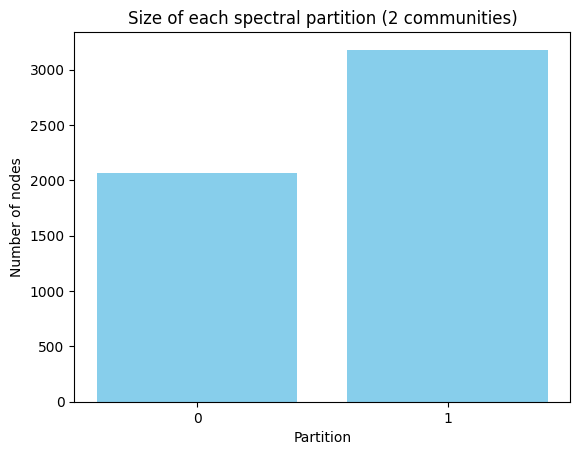

In [20]:

sizes = [len(nodes) for nodes in partitions.values()]

# Plot
plt.bar(range(len(sizes)), sizes, color='skyblue')
plt.xticks(range(len(sizes)), [i for i in range(len(sizes))])
plt.ylabel('Number of nodes')
plt.xlabel('Partition')
plt.title('Size of each spectral partition (2 communities)')
plt.show()


## KMeans

In [21]:
_vects_2_3_4 = eigvectors[:, 1:4] # get 2, 3, 4 eigenvectors - 3D - 3 n dim vectors
X = _vects_2_3_4

kmeans = KMeans(n_clusters = 4, n_init = 10, random_state = 0)
labels = kmeans.fit_predict(X)

In [22]:

partitions = {}
for i in np.unique(labels):
    partitions[i] = np.where(labels == i)[0]  # array indices

# Map back to actual node IDs if adjacency matrix corresponds to node order
nodes = list(G.nodes())
partitions = {i: [nodes[j] for j in idx] for i, idx in partitions.items()}

# Convert to list of sets for modularity
communities = [set(nodes) for nodes in partitions.values()]

# Compute modularity
mod = nx.algorithms.community.modularity(G, communities)

print("K-Means Modularity:", mod)


K-Means Modularity: 0.0009654505437138241


In [23]:
# Sizes of each community
sizes = [len(nodes) for nodes in partitions.values()]

# Print sizes
for i, size in enumerate(sizes):
    print(f"Community {i}: {size} nodes")



Community 0: 5229 nodes
Community 1: 2 nodes
Community 2: 3 nodes
Community 3: 8 nodes


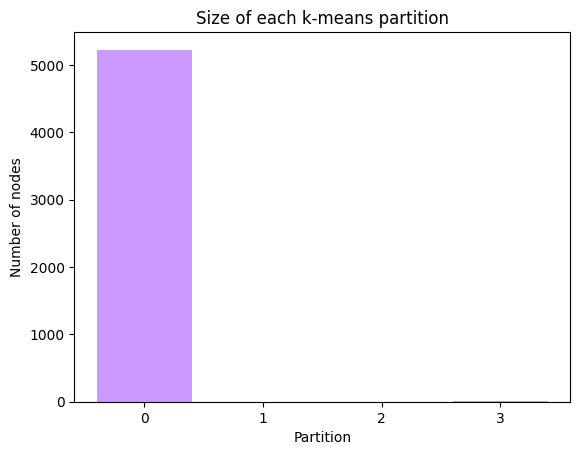

In [25]:
import matplotlib.pyplot as plt

plt.bar(range(len(sizes)), sizes, color=(0.8, 0.6, 1))
plt.xticks(range(len(sizes)), [i for i in range(len(sizes))])
plt.ylabel('Number of nodes')
plt.xlabel('Partition')
plt.title('Size of each k-means partition')
plt.show()


## Partitions

In [26]:
def spectral_partition(G, plot_sizes=True):
    import numpy as np
    import networkx as nx
    import matplotlib.pyplot as plt

    # Adjacency and Laplacian
    A = nx.to_numpy_array(G)
    degrees = [G.degree(n) for n in G.nodes()]
    D = np.diag(degrees)
    L = D - A

    # Eigen decomposition
    eigval, eigvectors = np.linalg.eigh(L)
    e2 = eigvectors[:, 1]  # Fiedler vector
    e2 = np.array(e2)

    nodes = list(G.nodes())
    partitions = {
        0: [nodes[i] for i in np.where(e2 < 0)[0]],
        1: [nodes[i] for i in np.where(e2 >= 0)[0]]
    }

    # Modularity
    communities = [set(nodes) for nodes in partitions.values()]
    mod = nx.algorithms.community.modularity(G, communities)

    # Plot sizes
    if plot_sizes:
        sizes = [len(nodes) for nodes in partitions.values()]
        plt.bar(range(len(sizes)), sizes, color='skyblue')
        plt.xticks(range(len(sizes)), [i for i in range(len(sizes))])
        plt.ylabel('Number of nodes')
        plt.xlabel('Partition')
        plt.title('Size of each spectral partition (2 communities)')
        plt.show()

    return partitions, mod


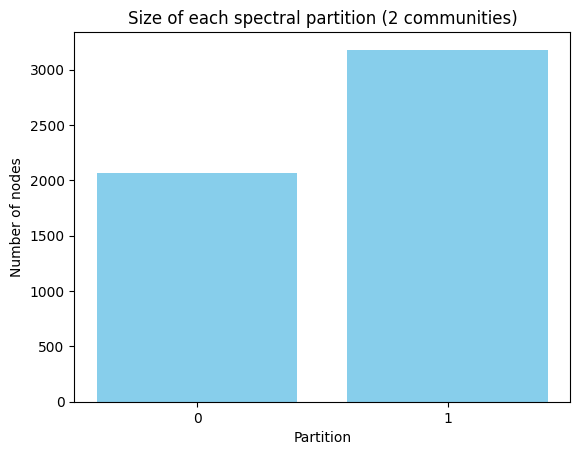

In [27]:
partitions, mod = spectral_partition(G)

In [28]:
print(mod)

0.23597738454682174


## Recursive Partions

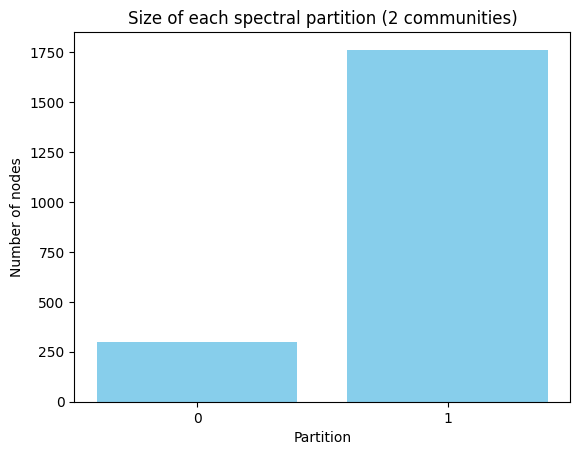

0.14305922554126757


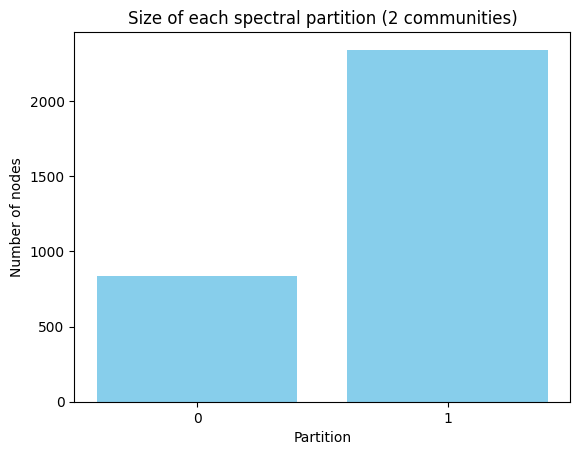

0.23809410386919508


In [29]:
part = []

for comm_nodes in partitions.values():  # iterate over node lists
    subgraph = G.subgraph(comm_nodes)   # create the subgraph
    parts, modnew = spectral_partition(subgraph)
    part.extend(parts.values())
    print(modnew)

    

In [30]:
communities = [set(comm_nodes) for comm_nodes in part]

# Calculate total modularity of the partition with respect to G
Q = nx.algorithms.community.quality.modularity(G, communities)

print("Total modularity:", Q)

Total modularity: 0.3575756792274888


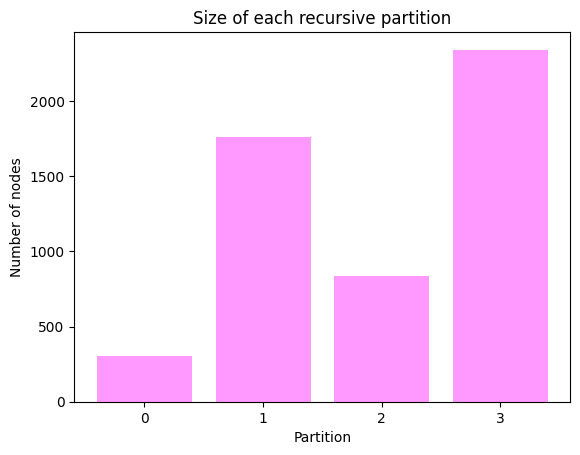

In [31]:
sizes = [len(p) for p in part]

plt.bar(range(len(sizes)), sizes, color=(1, 0.6, 1))
plt.xticks(range(len(sizes)), [i for i in range(len(sizes))])
plt.xlabel('Partition')
plt.ylabel('Number of nodes')
plt.title('Size of each recursive partition')
plt.show()


## From Previous

In [32]:
tosplit = [part[1], part[3]] # These are bigger

In [33]:
parts = [part[0], part[2]]

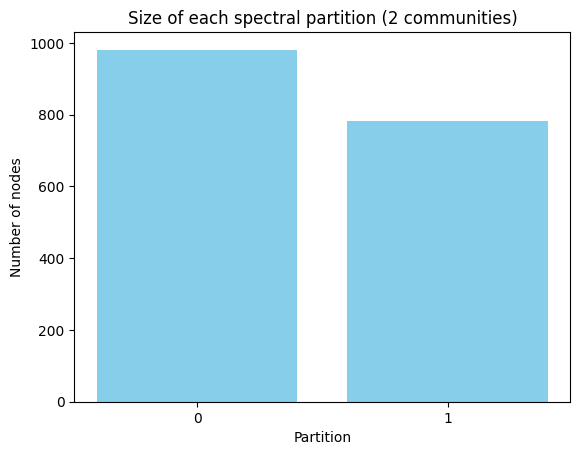

0.27156341025710384


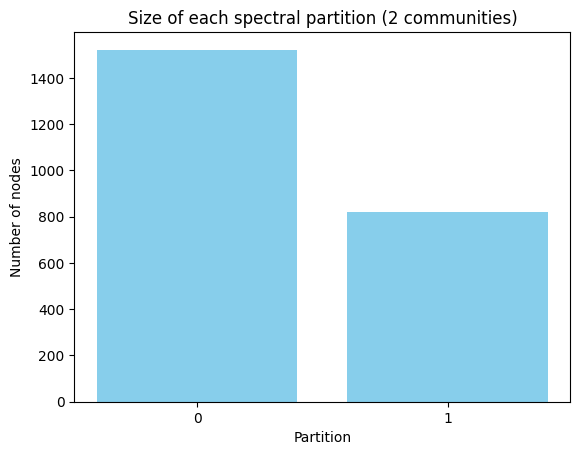

0.2033507468907538


In [34]:
for comm_nodes in tosplit:  # iterate over node lists
    subgraph = G.subgraph(comm_nodes)   # create the subgraph
    newpart, modnew = spectral_partition(subgraph)
    parts.extend(newpart.values())
    print(modnew) 

In [35]:
communities = [set(comm_nodes) for comm_nodes in parts]

# Calculate total modularity of the partition with respect to G
Q = nx.algorithms.community.quality.modularity(G, communities)

print("Total modularity:", Q)

Total modularity: 0.41016795443532567


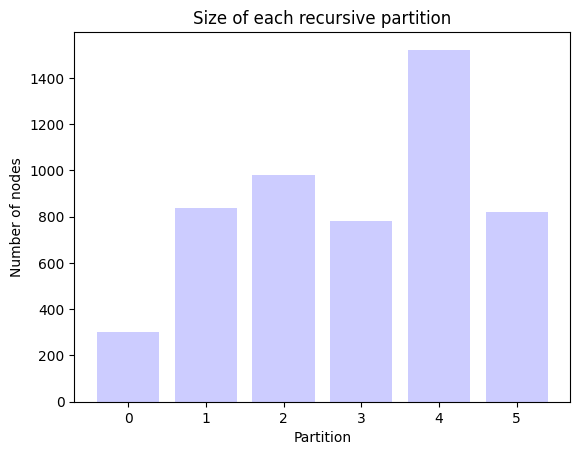

In [36]:
sizes = [len(p) for p in parts]

plt.bar(range(len(sizes)), sizes, color=(0.8, 0.8, 1))
plt.xticks(range(len(sizes)), [i for i in range(len(sizes))])
plt.xlabel('Partition')
plt.ylabel('Number of nodes')
plt.title('Size of each recursive partition')
plt.show()


## Splitting Code

In [37]:
def split(inds, parts):
    tosplit = [parts[i] for i in inds]  # communities to split

    for comm_nodes in tosplit:
        subgraph = G.subgraph(comm_nodes)
        newpart, modnew = spectral_partition(subgraph, plot_sizes=False)
        parts.remove(comm_nodes)           # remove old community
        parts.extend(newpart.values())     # add new sub-communities
        print("Local modularity:", modnew)

    communities = [set(comm_nodes) for comm_nodes in parts]

    # Calculate total modularity of the partition with respect to G
    Q = nx.algorithms.community.quality.modularity(G, communities)
    print("Total modularity:", Q)

    return communities


In [38]:
newcomms = split([4], parts[:])

Local modularity: 0.398154183142007
Total modularity: 0.47691118938116134


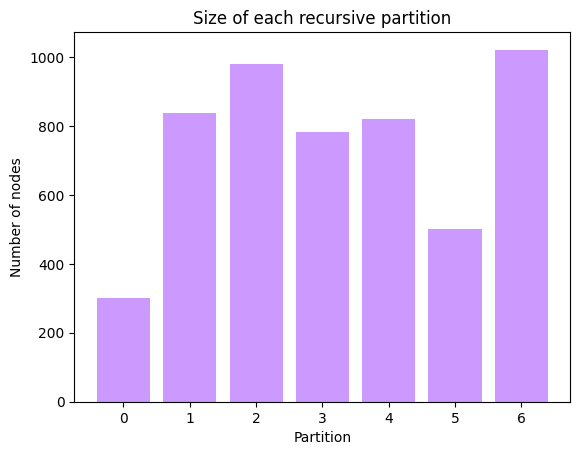

In [39]:
sizes = [len(p) for p in newcomms]

plt.bar(range(len(sizes)), sizes, color=(0.8, 0.6, 1))
plt.xticks(range(len(sizes)), [i for i in range(len(sizes))])
plt.xlabel('Partition')
plt.ylabel('Number of nodes')
plt.title('Size of each recursive partition')
plt.show()


In [40]:
max(sizes)/2

510.5

In [41]:
def split_threshold(parts, threshold):
    tosplit = [p for p in parts if len(p)>= threshold]  # communities to split

    for comm_nodes in tosplit:
        subgraph = G.subgraph(comm_nodes)
        newpart, modnew = spectral_partition(subgraph, plot_sizes=False)
        parts.remove(comm_nodes)           # remove old community
        parts.extend(newpart.values())     # add new sub-communities
        print("Local modularity:", modnew)

    communities = [set(comm_nodes) for comm_nodes in parts]

    # Calculate total modularity of the partition with respect to G
    Q = nx.algorithms.community.quality.modularity(G, communities)
    print("\n Total modularity:", Q)

    return communities


In [42]:
newparts = split_threshold(newcomms[:], 510.5)

Local modularity: 0.2788813290986638
Local modularity: 0.40839048517165727
Local modularity: 0.4084220095452136
Local modularity: 0.46666102109992424
Local modularity: 0.1077242025711549

 Total modularity: 0.5078759547430911


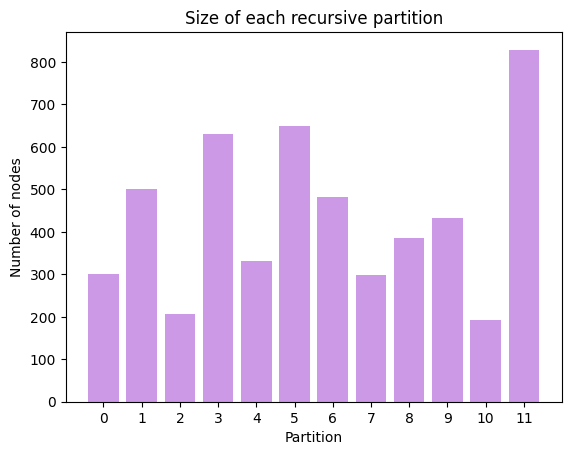

In [43]:
sizes = [len(p) for p in newparts]

plt.bar(range(len(sizes)), sizes, color=(0.8, 0.6, 0.9))
plt.xticks(range(len(sizes)), [i for i in range(len(sizes))])
plt.xlabel('Partition')
plt.ylabel('Number of nodes')
plt.title('Size of each recursive partition')
plt.show()


Local modularity: 0.3582648664176961
Local modularity: 0.3075936883629191
Local modularity: 0.4658049910784283
Local modularity: 0.33693002691272583
Local modularity: 0.36573212348512013
Local modularity: 0.4246662242119656
Local modularity: 0.35918834547346506
Local modularity: 0.4592730688495049
Local modularity: 0.4709131148854351
Local modularity: 0.18353274443244155

 Total modularity: 0.5100103688114922


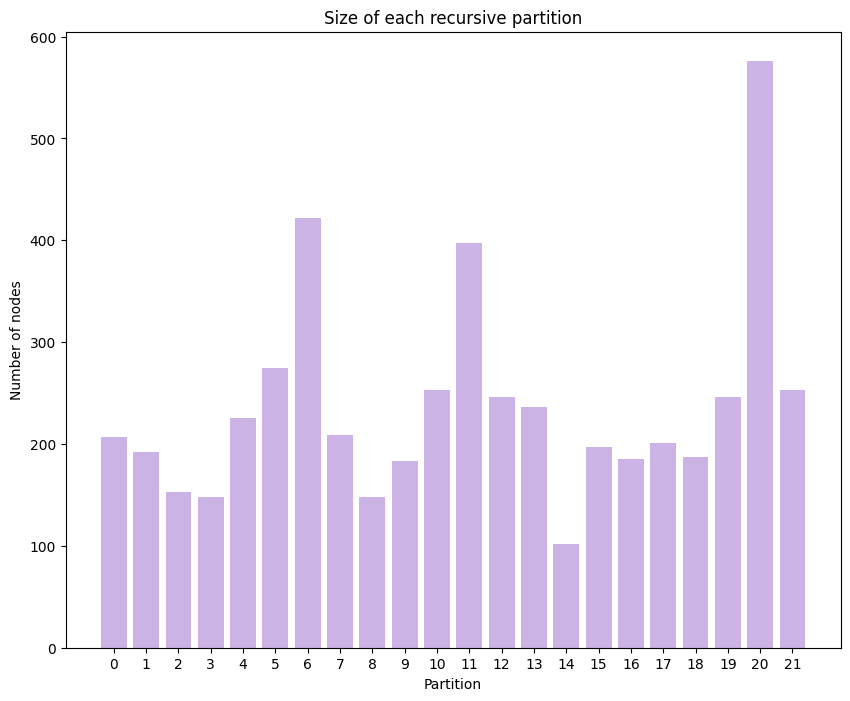

In [49]:
newparts2 = split_threshold(newparts[:], max(sizes)/2)

sizes = [len(p) for p in newparts2]

plt.figure(figsize=(10, 8))

plt.bar(range(len(sizes)), sizes, color=(0.8, 0.7, 0.9))
plt.xticks(range(len(sizes)), [i for i in range(len(sizes))])
plt.xlabel('Partition')
plt.ylabel('Number of nodes')
plt.title('Size of each recursive partition')
plt.show()

Local modularity: 0.1890214744382328
Total modularity: 0.4877836960961142


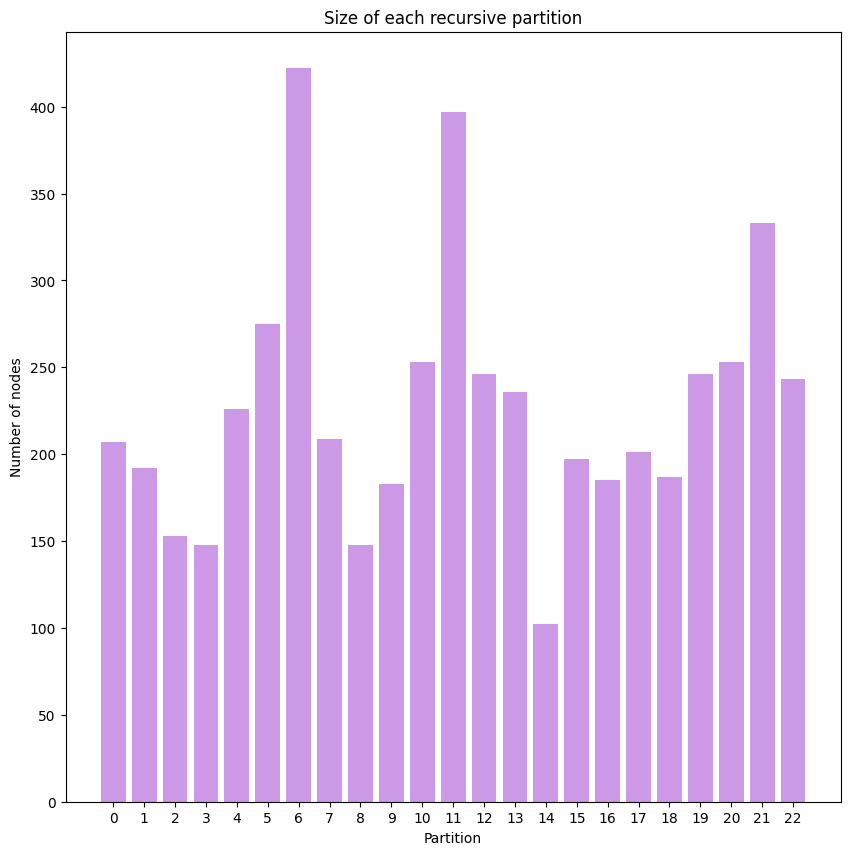

In [48]:
newparts4 = split([20],newparts2[:])

sizes = [len(p) for p in newparts4]

plt.figure(figsize=(10, 10))

plt.bar(range(len(sizes)), sizes, color=(0.8, 0.6, 0.9))
plt.xticks(range(len(sizes)), [i for i in range(len(sizes))])
plt.xlabel('Partition')
plt.ylabel('Number of nodes')
plt.title('Size of each recursive partition')
plt.show()

## Some Trials

Local modularity: 0.4658049910784283
Local modularity: 0.36573212348512013
Local modularity: 0.18353274443244155
Total modularity: 0.5135756031046397


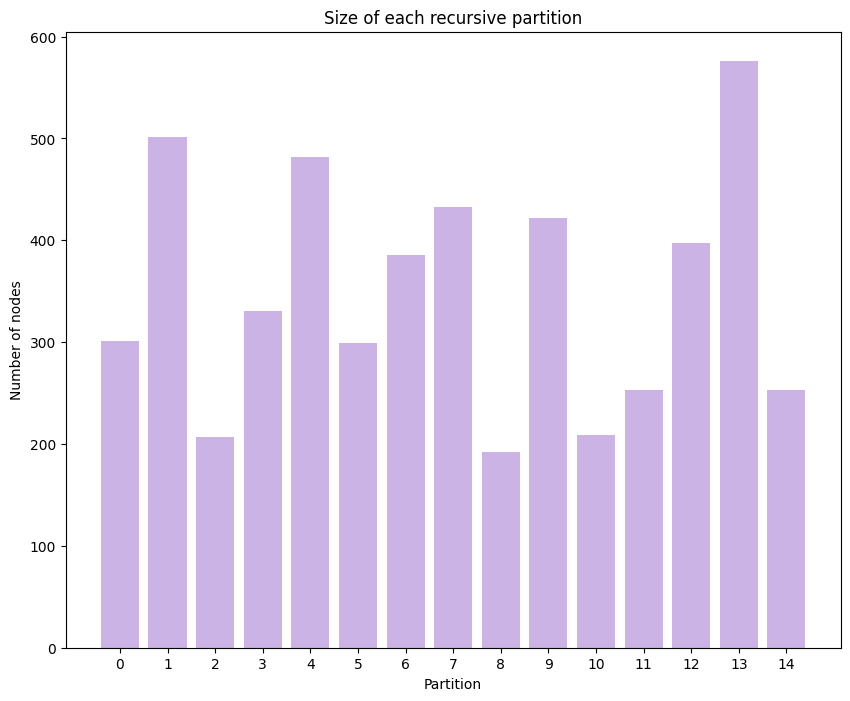

In [52]:
newpartstrial = split([3, 5, 11], newparts[:])

sizes = [len(p) for p in newpartstrial]

plt.figure(figsize=(10, 8))

plt.bar(range(len(sizes)), sizes, color=(0.8, 0.7, 0.9))
plt.xticks(range(len(sizes)), [i for i in range(len(sizes))])
plt.xlabel('Partition')
plt.ylabel('Number of nodes')
plt.title('Size of each recursive partition')
plt.show()

In [55]:
sizes

[301,
 207,
 331,
 299,
 386,
 433,
 192,
 422,
 209,
 253,
 397,
 253,
 226,
 275,
 246,
 236,
 333,
 243]

In [56]:
np.std(sizes)

np.float64(74.31805190871307)

In [57]:
np.mean(sizes)

np.float64(291.22222222222223)

In [58]:
min(sizes)

192

In [59]:
max(sizes)

433

In [60]:
np.median(sizes)

np.float64(264.0)